# <a name="0">Machine Learning Accelerator - Natural Language Processing - Lecture 1</a>

## Logistic Regression Model for a Classification Problem: Classify Product Reviews as Positive or Negative

In this notebook, we use the Pytorch library to build a logistic regression model as a single layer neural network. Then, we will classify product reviews as positive or negative (similar to the final project dataset that you will see).


1. <a href="#1">Reading the dataset</a>
2. <a href="#2">Exploratory data analysis</a>
3. <a href="#3">Text Processing: Stop words removal and stemming</a>
4. <a href="#4">Train - Validation Split</a>
5. <a href="#5">Data processing with Pipeline</a>
6. <a href="#6">Train the classifier</a>
7. <a href="#7">Make predictions on the validation data and test the classifier</a>
8. <a href="#8">Getting predictions on the test data and saving results</a>
9. <a href="#9">Ideas for improvement</a>

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes). *This field is a processed version of the votes field. People can click on the "helpful" button when they find a customer review helpful. This increases the vote by 1. __log_votes__ is calculated like this log(1+votes). This formulation helps us get a smaller range for votes.*
* __isPositive:__ Whether the review is positive or negative (1 or 0)


In [1]:
# Upgrade dependencies
!pip install -r ../../requirements.txt

  Using cached torch-1.8.1-cp36-cp36m-manylinux1_x86_64.whl (804.1 MB)
  Using cached torchtext-0.9.1-cp36-cp36m-manylinux1_x86_64.whl (7.1 MB)
  Using cached scikit_learn-0.24.1-cp36-cp36m-manylinux2010_x86_64.whl (22.2 MB)
  Using cached trax-1.3.7-py2.py3-none-any.whl (521 kB)
  Using cached transformers-4.5.1-py3-none-any.whl (2.1 MB)
  Using cached tensorflow_datasets-4.4.0-py3-none-any.whl (4.0 MB)
  Using cached funcsigs-1.0.2-py2.py3-none-any.whl (17 kB)
  Using cached tensorflow_text-2.6.0-cp36-cp36m-manylinux1_x86_64.whl (4.4 MB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Using cached jaxlib-0.1.69-cp36-none-manylinux2010_x86_64.whl (46.5 MB)
  Using cached t5-0.9.3-py3-none-any.whl (153 kB)
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)
  Using cached jax-0.2.17.tar.gz (693 kB)
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
  Using cached tokenizers-0.10.3-cp36-cp36m-manylinux_2_5_x86_64.manylinux1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 458.3 MB 7.1 kB/s s eta 0:00:01
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached keras-2.6.0-py2.py3-none-any.whl (1.3 MB)
  Using cached grpcio-1.42.0-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.0 MB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.6.0-py2.py3-none-any.whl (462 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached t

In [2]:
import boto3
import os
import numpy as np
import pandas as pd
import nltk, re
import time
import torch
import torch.nn as nn

from os import path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn import BCELoss
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. <a name="1">Reading the dataset</a>
(<a href="#0">Go to top</a>)

We will first download the dataset and then use the __pandas__ library to read it.

In [3]:
df = pd.read_csv("../../data/examples/NLP-REVIEW-DATA-CLASSIFICATION-TRAINING.csv")

print(f"The shape of the dataset is: {df.shape}")

The shape of the dataset is: (56000, 7)


Let's look at the first 10 rows of the dataset. 

In [4]:
df.head(10)

,ID,reviewText,summary,verified,time,log_votes,isPositive
0,65886,Purchased as a quick fix for a needed Server 2...,"Easy install, seamless migration",True,1458864000,0.000000,1.0
1,19822,So far so good. Installation was simple. And r...,Five Stars,True,1417478400,0.000000,1.0
2,14558,Microsoft keeps making Visual Studio better. I...,This is the best development tool I've ever used.,False,1252886400,0.000000,1.0
3,39708,Very good product.,Very good product.,True,1458604800,0.000000,1.0
4,8015,So very different from my last version and I a...,... from my last version and I am having a gre...,True,1454716800,2.197225,0.0
5,44530,"The course is easy to follow, explicit instruc...",Well worth the money!,False,1448496000,0.000000,1.0
6,19648,Microsoft claims Streets & Trips 2008 is compa...,Microsoft Lies : Vista sucks : How to use it a...,False,1231891200,0.000000,0.0
7,3360,"The user interface is clunky. For example, the...","Too bad it isn't better; also, installation pr...",False,1335398400,0.000000,0.0
8,25378,They will automatically bill you for $179 afte...,Beware signing up for free 3 months online,False,1167350400,2.397895,0.0
9,20006,Download the free complete version from Corel ...,Mutiple crashes,False,1259452800,1.098612,0.0


## 2. <a name="2">Exploratory data analysis</a>
(<a href="#0">Go to top</a>)

Let's look at the distribution of __isPositive__ field.

In [5]:
df["isPositive"].value_counts()

1.0    34954
0.0    21046
Name: isPositive, dtype: int64

We can check the number of missing values for each columm below.

In [6]:
print(df.isna().sum())

ID             0
reviewText    10
summary       12
verified       0
time           0
log_votes      0
isPositive     0
dtype: int64


We have missing values in our text fields. We will use the __reviewText__ field, so we fill-in the missing values in it with the empty string.

In [7]:
df["reviewText"].fillna("", inplace=True)

## 3. <a name="3">Text Processing: Stop words removal and stemming</a>
(<a href="#0">Go to top</a>)

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [8]:
# Let's get a list of stop words from the NLTK library
stop = stopwords.words("english")

# These words are important for our problem. We don't want to remove them.
excluding = [
    "against",
    "not",
    "don",
    "don't",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "won",
    "won't",
    "wouldn",
    "wouldn't",
]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer("english")

def process_text(texts):
    final_text_list = []
    for sent in texts:

        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""

        filtered_sentence = []
        
        # Lowercase
        sent = sent.lower()
        # Remove leading/trailing whitespace
        sent = sent.strip()
        # Remove extra space and tabs
        sent = re.sub("\s+", " ", sent)
        # Remove HTML tags/markups:
        sent = re.compile("<.*?>").sub("", sent)

        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if (not w.isnumeric()) and (len(w) > 2) and (w not in stop_words):
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence)  # final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

Let's inspect the effect of our preprocessing on some text from our data set

In [9]:
review = df.reviewText.iloc[0]
print(f"Raw text: \n{review}\n")
print(f"Preprocessed text:\n{process_text([review])}")

Raw text: 
Purchased as a quick fix for a needed Server 2003 R2 upgrade. Easy install, seamless migration. Not much MS full support left on it though. This was a one-of-a kind purchase to meet an upgrade need at a low cost. Probably a lucky find. Service and delivery were good AND the activation code worked without a burp.

Preprocessed text:
['purchas quick fix need server upgrad easi instal seamless migrat not much full support left though one-of-a kind purchas meet upgrad need low cost probabl lucki find servic deliveri good activ code work without burp']


In [10]:
review = df.reviewText.iloc[20]
print(f"Raw text: \n{review}\n")
print(f"Preprocessed text:\n{process_text([review])}")

Raw text: 
I use it regularly. Great for organizing and keeping up with dates.

Preprocessed text:
['use regular great organ keep date']


## 4. <a name="4">Train - Validation Split</a>
(<a href="#0">Go to top</a>)

Let's split our dataset into training (90%) and validation (10%). 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df[["reviewText"]],
    df["isPositive"].values,
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

In [12]:
print("Processing the reviewText fields...")
X_train["reviewText"] = process_text(X_train["reviewText"].tolist())
X_val["reviewText"] = process_text(X_val["reviewText"].tolist())

Processing the reviewText fields...


In [13]:
# Use TD-IDF to vectorize to vectors of len 750.
tf_idf_vectorizer = TfidfVectorizer(max_features=750)

# Fit the vectorizer to training data
# Don't use the fit() on validation or test datasets
tf_idf_vectorizer.fit(X_train["reviewText"].values)

# Transform text fields
X_train = tf_idf_vectorizer.transform(X_train["reviewText"].values).toarray()
X_val = tf_idf_vectorizer.transform(X_val["reviewText"].values).toarray()

print("Shapes of features: Training and Validation")
print(X_train.shape, X_val.shape)

Shapes of features: Training and Validation
(50400, 750) (5600, 750)


We can inspect the tokens in the vocabulary (which we've set to be of size 750)

In [14]:
tf_idf_vectorizer.get_feature_names()[:10]

['10',
 'abil',
 'abl',
 'absolut',
 'accept',
 'access',
 'account',
 'accur',
 'activ',
 'actual']

Our __process_text()__ method in section 3 uses empty string for missing values.

## 6. <a name="6">Train the classifier</a>
(<a href="#0">Go to top</a>)

## Single Layer Network/Logistic Regression 

To handle this binary classification problem, let's first consider a logistic regression model, mapping the input $\mathbf{X}$ to the output $\mathbf{y}$ by

$$
\mathbf{\hat{y}} = \mathrm{sigmoid}(\mathbf{X}\mathbf{w} + \mathbf{b}),
$$

with some initial choices for the parameters, $\mathbf{w}$ weights matrix and bias $\mathbf{b}$. We initialize the weights as random Gaussian noise, with zero mean and standard deviation 1, and start with zero bias.


Let's introduce the single layer networks! We use the Pytorch library here. In this first part, we do the following:
* Select our hyper-parameters to use in this problem
* Build the network
* Define loss function and optimizer
* Create data loaders

In [15]:
# How many samples to use for each weight update
batch_size = 16
# Total number of iterations
# One epoch is one pass over all data in the training set
epochs = 15
# Learning rate
lr = 0.01

# Run the training in the GPU if supported by our instance, else in the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Let's build our single layer network (logistic regression here)
net = nn.Sequential(
    nn.Linear(in_features=750, # matches the size of vectorizer: 750
              out_features=1), 
    nn.Sigmoid()
)
net.to(device)

# Initialize the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=1)
        nn.init.zeros_(m.bias)
net.apply(init_weights)

# Define the loss. For binary classification the appropriate choice is Binary Cross Entropy.
# As we used sigmoid in the last layer, we use `nn.BCELoss`.
# Otherwise we could have made use of `nn.BCEWithLogitsLoss`.
loss = BCELoss(reduction="none")

# Define the optimizer, SGD (Stochastic Gradient Descent) with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Use PyTorch DataLoaders to load the data in batches
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

After these, we are ready to train this network. See below for the training and validation code. At high level, we have three main parts: 

__1. Epochs loop:__ Loop over your datast to learn and update your weights. Neural networks usually need to see the dataset multiple times to learn the better (this can be considered a slow process).

__2. Training loop:__ During the training, we loop over the data loader. Data loader loads the data in batches. We selected batch size earlier. Here, the weights are updated for each batch.

__3. Validation:__ After the training loop is done, we go over the validation data and calculate the validation loss.

In [16]:
# Lists to store the losses as the training progresses
train_losses = []
val_losses = []

# Loop over epochs
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop to train the network
    for data, target in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device).view(-1, 1)

        # Forward pass - compute the predictions of the NN on the batch
        output = net(data)  
        # Compute the loss and sum (error between the net's predictions and the actual labels)
        L = loss(output, target).sum()
        training_loss += L.item() 
        # Calculate gradients
        L.backward()  
        # Update weights with gradient descent
        optimizer.step()  

    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()

    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}, Validation_loss {val_loss}, Seconds {end-start}"
    )

Epoch 0. Train_loss 0.6074669294508677, Validation_loss 0.5327882603236607, Seconds 1.9980592727661133
Epoch 1. Train_loss 0.4913513486820554, Validation_loss 0.4718841552734375, Seconds 2.05788254737854
Epoch 2. Train_loss 0.448418990118163, Validation_loss 0.44151929582868304, Seconds 1.977966070175171
Epoch 3. Train_loss 0.4245563501025003, Validation_loss 0.4227579171316964, Seconds 1.9499552249908447
Epoch 4. Train_loss 0.4089667638403083, Validation_loss 0.4099011666434152, Seconds 2.079286813735962
Epoch 5. Train_loss 0.39789008383003494, Validation_loss 0.4005377197265625, Seconds 2.0015697479248047
Epoch 6. Train_loss 0.3895980614163573, Validation_loss 0.3934344482421875, Seconds 2.0712027549743652
Epoch 7. Train_loss 0.38316069374718364, Validation_loss 0.3878836495535714, Seconds 2.20481014251709
Epoch 8. Train_loss 0.3780253144933118, Validation_loss 0.3834462629045759, Seconds 1.9737942218780518
Epoch 9. Train_loss 0.37384031818263114, Validation_loss 0.37983407156808036,

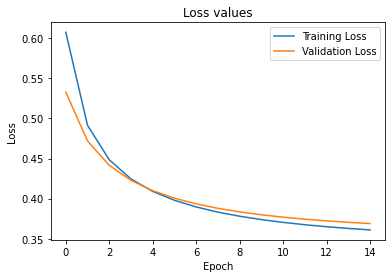

In [17]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 7. <a name="7">Make predictions on the validation data and test the classifier</a>
(<a href="#0">Go to top</a>)

Let's get the validation predictions with this ```val_predictions = net(X_val)```. Then, we look at our validation data performance. See comments in the code for more details.

In [18]:
# Get predictions using the trained network: "net"
val_predictions = net(X_val)
# Round up (to 1) or down (to 0) the result (remember the sigmoid).
# Use np.rint() for that
val_predictions = np.rint(val_predictions.detach().cpu().numpy())
print(val_predictions)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


Let's get rid of the one extra level in this array. We will simply use the np.squeeze() function. 

In [19]:
val_predictions = np.squeeze(val_predictions)
print(val_predictions)

[1. 1. 1. ... 1. 1. 0.]


Confusion matrix, classification report and accuracy score are printed below.

In [20]:
y_val = y_val.detach().cpu().numpy()
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("Accuracy (validation):", accuracy_score(y_val, val_predictions))

[[1504  548]
 [ 401 3147]]
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      2052
         1.0       0.85      0.89      0.87      3548

    accuracy                           0.83      5600
   macro avg       0.82      0.81      0.81      5600
weighted avg       0.83      0.83      0.83      5600

Accuracy (validation): 0.8305357142857143


## 8. <a name="8">Getting predictions on the test data and saving results</a>

In [21]:
df_test = pd.read_csv("../../data/examples/NLP-REVIEW-DATA-CLASSIFICATION-TEST.csv")

In [22]:
X_test = process_text(df_test["reviewText"].tolist())

In [23]:
X_test = tf_idf_vectorizer.transform(X_test).toarray()

print("Shapes of features: Training and Validation")
print(X_test.shape)

Shapes of features: Training and Validation
(14000, 750)


In [24]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
print(X_test.shape)

torch.Size([14000, 750])


In [25]:
# Get predictions using the trained network: "net"
test_predictions = net(X_test)
# Round up (to 1) or down (to 0) the result (remember the sigmoid).
# Use np.rint() for that
test_predictions = np.rint(test_predictions.detach().cpu().numpy())
print(test_predictions)

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


In [26]:
test_predictions = np.squeeze(test_predictions)
print(test_predictions)

[0. 1. 1. ... 1. 0. 1.]


In [27]:
import pandas as pd

result_df = pd.DataFrame()
result_df["ID"] = df_test["ID"]
result_df["isPositive"] = test_predictions

result_df.to_csv("result_day1_logistic_regr.csv", encoding='utf-8', index=False)

## 9. <a name="9">Ideas for improvement</a>
(<a href="#0">Go to top</a>)

We can usually improve performance with some additional work. You can try the following:
* Experiment with different values for the hyperparameters: Batch size and learning rate.
* How about adding another layer? It is tomorrow's topic, but you can try adding another layer. Check out the MLA-NLP-DAY2-NN-NB notebook from tomorrow's content if you are interested.
* Come up with some other features such as having certain punctuations, all-capitalized words or some words that might be useful in this problem.